_Version log: Finding the best samples though brute force and manual tweaking_

In [99]:
import CS_functions as cs
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, colors as mplcolors
plt.rcParams.update({'font.size':16})
#np.set_printoptions(threshold=sys.maxsize)

In [100]:
file_name = "1dmockanderrors15"
file_type = ".csv"
reduced_points = 4

target, uncertainties = cs.open_dataset(file_name, file_type)
#uncertainties = np.ones_like(uncertainties)
total_points = len(target)
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [101]:
full_data = cs.open_csv(optlocs_file, reduced_points)

In [102]:
#test = [11,15,24,27,44,66,85,126] #PCA
#test = [72,76,79,89,96,100,107,117] #RPCA
#test = [0,88,94,100,104,124,165,190] #[31,55,62,70,79,83,93,100,104,111,125,132,139,149,159,197] # Manual
#test = [41,42,45,46,58,59,63,65] # SA
#test = [18,36,52,56,59,71,77,86] #MCMC
test = [81,102,104,116] #Brute force
#test = cs.subsample_1d(total_points, reduced_points, subsampling_method= "regular") # referance

test = np.array(test)

len(test)

4

In [103]:
np.diff(test)

array([21,  2, 12])

In [104]:
full_data = np.vstack([full_data, test])
full_data.shape

(21, 4)

In [105]:
regularization_coeffient = 1e-4

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    samples = np.full_like(target, np.nan)
    samples[locations] = target[locations]
    result = cs.compressed_sensing(samples, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

errors = [find_error(locations) for locations in tqdm(full_data)]
errors = np.array(errors)


100%|██████████| 21/21 [00:00<00:00, 76.44it/s] 


In [106]:
sort = np.argsort(errors)
print(errors[-1])
errors = errors[sort]
full_data = full_data[sort]

1.0735858691855107


In [107]:
print(*zip(errors, full_data), sep= "\n")

(1.0735858691855107, array([ 81, 102, 104, 116]))
(1.0735858691855107, array([ 81, 102, 104, 116]))
(1.1480341804369845, array([  1,   8, 102, 104]))
(1.253350229261434, array([  6,  95,  97, 199]))
(1.2820373602549553, array([  0,  95,  97, 194]))
(1.3737635968197868, array([  7, 102, 104, 197]))
(1.3956289696156412, array([  6, 102, 104, 199]))
(1.5002207157719436, array([ 88,  97, 100, 103]))
(1.601114884449193, array([ 95,  97, 110, 198]))
(1.7123472323855777, array([ 68,  95,  97, 174]))
(1.9775587444459144, array([102, 104, 145, 173]))
(2.0351236334431304, array([ 5, 69, 95, 97]))
(2.156430645429864, array([  0,  95,  97, 139]))
(2.373254245251086, array([  3, 109, 111, 199]))
(2.683756801236484, array([110, 115, 118, 167]))
(2.966685399069876, array([ 78, 131, 162, 176]))
(3.022481553676229, array([ 77, 117, 124, 143]))
(3.039392627362968, array([ 76,  83, 122, 170]))
(3.0654619399207013, array([ 43,  66, 121, 188]))
(3.0690899641971967, array([ 58,  70, 119, 150]))
(3.081921810

In [108]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

0.0


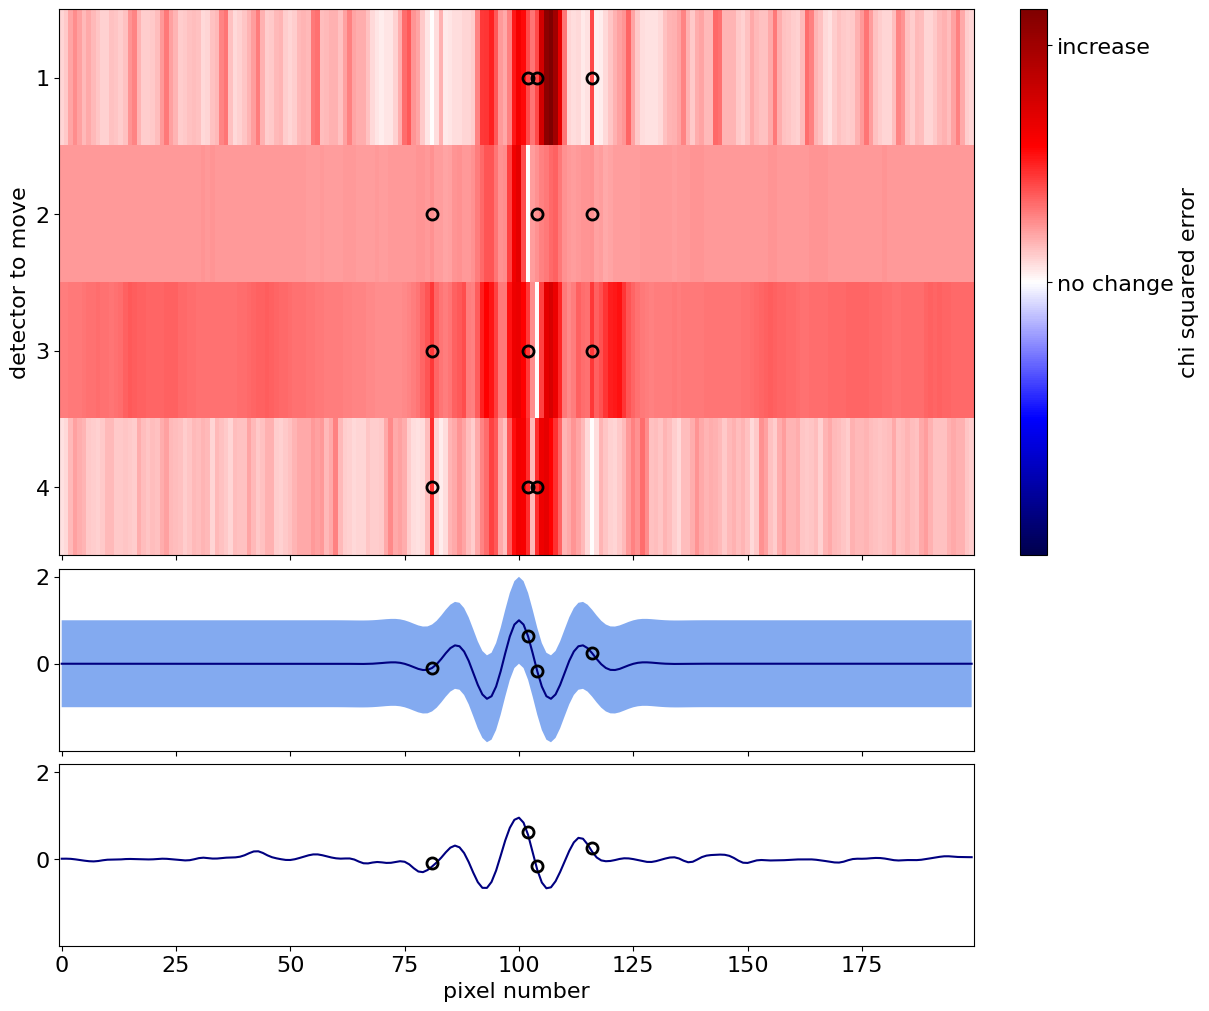

In [109]:
difference = brute_errors -sa_error

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.
if min_diff >= 0: min_diff = -1 #If this is more than or equal to zero then my code breaks!

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

zticklabels = np.full_like(zticks, "", dtype= object)
zticklabels[0] = "decrease"
zticklabels[-1] = "increase"
zticklabels[zticks == 0] = "no change"

fig, axs = plt.subplots(3, 1, figsize= (12, 10), sharex= True, height_ratios= (3, 1, 1), layout= "constrained")

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements
im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= "seismic", norm= norm)
cbar = fig.colorbar(im, label= "chi squared error")
cbar.set_ticks(ticks= zticks, labels=zticklabels)

axs[0].plot(fixed_points ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "detector to move", yticks= np.arange(reduced_points), yticklabels= np.arange(1, reduced_points+1))

axs[1].plot(target, color= "navy", label= "actual signal")
axs[1].fill_between(range(total_points), target-uncertainties, target+uncertainties, facecolor= "cornflowerblue", alpha= 0.8, label= "± std uncertrainty")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)

samples = np.full_like(target, np.nan)
samples[test] = target[test]

axs[2].plot(cs.compressed_sensing(samples, regularization_coeffient), color= "navy")
axs[2].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8)
axs[2].set(xlabel= "pixel number", ylim= axs[1].get_ylim())

plt.show()